# Assignment 3

**Martin, Erik : 250660**  
**Seim, Håvard : 260699**  
**Group: L**  

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time

# 1. Problem Basic Graph

In [31]:
#       1  2  3  4  5  6
Adj = [[0, 1, 0, 0, 0, 0], # 1
       [0, 1, 1, 1, 0, 0], # 2
       [1, 1, 0 ,0, 1, 0], # 3
       [0, 0, 0, 0, 1, 1], # 4
       [0, 0, 1, 1, 0, 0], # 5
       [0, 0, 0, 1, 0, 0]] # 6

## 1. Convert the adjacency matrix to an adjacency list. The adjacent lists need to be in alphabetical order.
We are assuming that *in alphabetical order* means that the nodes are sorted by numbers, which gives this adjacency list:

| Node | Neighbors |
|------|-----------|
| 1    | 3         |
| 2    | 1, 2, 3   |
| 3    | 2, 5      |
| 4    | 2, 5, 6   |
| 5    | 3, 4      |
| 6    | 4         |


## 2. Draw the adjacency matrix in graph form.
We use networkx to draw the nodes and edges.

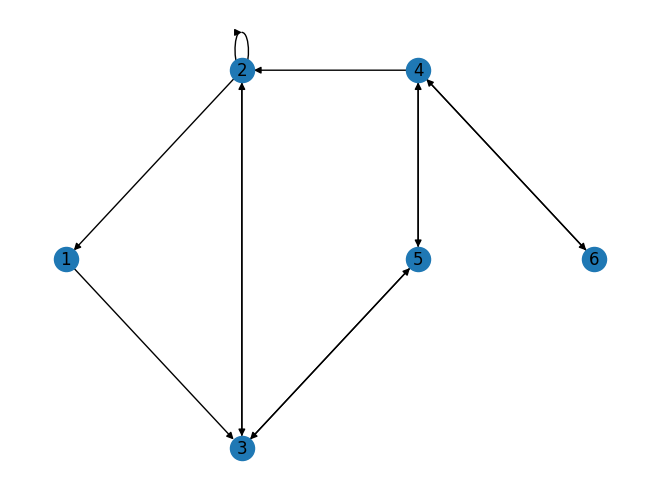

In [98]:
G = nx.DiGraph()
# Node 1
G.add_edge(1, 3)
# Node 2
G.add_edge(2, 1)
G.add_edge(2, 2)
G.add_edge(2, 3)
# Node 3
G.add_edge(3, 2)
G.add_edge(3, 5)
# Node 4
G.add_edge(4, 2)
G.add_edge(4, 5)
G.add_edge(4, 6)
# Node 5
G.add_edge(5, 3)
G.add_edge(5, 4)
# Node 6
G.add_edge(6, 4)

nx.draw(G, with_labels=True, pos={1: (0, -1), 2: (1, -0.5), 3: (1, -1.5), 4: (2, -0.5), 5: (2, -1), 6: (3, -1)})

## Make an adjacent list out of the graph in Figure 1 which also needs to be in alphabetical order.


| Node | Neighbors |
|------|-----------|
| A    | B         |
| B    | C, D      |
| C    | E, F      |
| D    | E, F      |
| E    | F, G      |
| F    | B, G, H, J|
| G    |           |
| H    | I         |
| I    |           |
| J    | I         |

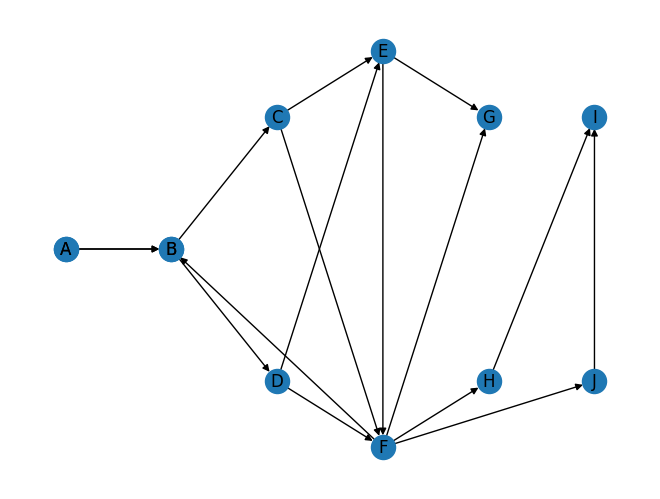

In [140]:
G = nx.DiGraph()

G.add_edge("A", "B")

G.add_edge("B", "C")
G.add_edge("B", "D")

G.add_edge("C", "E")
G.add_edge("C", "F")

G.add_edge("D", "E")
G.add_edge("D", "F")

G.add_edge("E", "F")
G.add_edge("E", "G")

G.add_edge("F", "B")
G.add_edge("F", "G")
G.add_edge("F", "H")
G.add_edge("F", "J")

G.add_edge("H", "I")

G.add_edge("J", "I")



nx.draw(G, with_labels=True,
        pos={
            "A": (0, 0),
            "B": (1, 0),
            "C": (2, 0.5),
            "D": (2, -0.5),
            "E": (3, 0.75),
            "F": (3, -0.75),
            "G": (4, 0.5),
            "H": (4, -0.5),
            "I": (5, 0.5),
            "J": (5, -0.5),
        }
)

## 1. b)
*Given a graph G = (V, E) and a source vertex s, execute both Depth-First Search (DFS) and Breadth-First Search (BFS) algorithms. Show the process by doing it manually on the graph depicted in Figure 1 with source vertex A (you can also do it with code, but then you need to include screenshots that clearly show the process). When visiting neighbors, visit them in alphabetical order. Each edge has a weight of 1. Don’t forget to incorporate the start and finish times.*

**The algorithms were implemented using the pseudocode from Introduction to Algorithms. BFS p. 595 and DFS p. 604**

## BFS
Point: BFS explores all neighbors at the present depth prior to moving on to the nodes at the next depth level. It uses a queue to keep track of the next vertex to explore, ensuring that vertices are explored in order of their distance from the starting point.

## DFS
Point: DFS explores as far as possible along each branch before backtracking. It uses a stack (either implicitly via recursion or explicitly using a data structure) to keep track of the next vertex to explore.

In [234]:
class Node:
    def __init__(self, name: str, weight: int = 0,  neighbours: list[tuple[str, int]] = []):
        self.name = name
        self.weight = weight
        self.neighbours: list[Node] = neighbours
        self.color = "white" # White before u.d time, gray between u.d and u.f and black after
        self.pi: Node = None  # Predecessor node
        self.d = np.inf  # Discovery time
        self.f = np.inf  # Finishing time

        self.neighbour_to_node()

    def __str__(self):
        neighbours = [
            (
                n.name, 
                n.weight, 
                n.color, 
                n.pi.name if n.pi else None, 
                n.d, 
                n.f
            )
            for n in self.neighbours
        ]
        return f"{self.name}: {neighbours}"
        
    def neighbour_to_node(self):
        n = []
        for neighbour in self.neighbours:
            neighbour = Node(name=neighbour[0], weight=neighbour[1])
            n.append(neighbour)
        self.neighbours = n

class Graph:
    def __init__(self, nodes: list[Node] = []):
        self.nodes = sorted(nodes, key=lambda x: x.name)

    def get(self, name: str):
        for node in self.nodes:
            if node.name == name:
                return node
        return None

    def graphical(self):
        for node in self.nodes:
            print(node)
    

In [235]:

graph = Graph([
    Node("A", 0, [("B", 1)]),
    Node("B", 0, [("C", 1), ("D", 1)]),
    Node("C", 0, [("E", 1), ("F", 1)]),
    Node("D", 0, [("E", 1), ("F", 1)]),
    Node("E", 0, [("F", 1), ("G", 1)]),
    Node("F", 0, [("B", 1), ("G", 1), ("H", 1), ("J", 1)]),
    Node("G", 0, []),
    Node("H", 0, [("I", 1)]),
    Node("I", 0, []),
    Node("J", 0, [("I", 1)])
])

print(graph.graphical())
print(graph.get("A").d.imag)

A: [('B', 1, 'white', None, inf, inf)]
B: [('C', 1, 'white', None, inf, inf), ('D', 1, 'white', None, inf, inf)]
C: [('E', 1, 'white', None, inf, inf), ('F', 1, 'white', None, inf, inf)]
D: [('E', 1, 'white', None, inf, inf), ('F', 1, 'white', None, inf, inf)]
E: [('F', 1, 'white', None, inf, inf), ('G', 1, 'white', None, inf, inf)]
F: [('B', 1, 'white', None, inf, inf), ('G', 1, 'white', None, inf, inf), ('H', 1, 'white', None, inf, inf), ('J', 1, 'white', None, inf, inf)]
G: []
H: [('I', 1, 'white', None, inf, inf)]
I: []
J: [('I', 1, 'white', None, inf, inf)]
None
0.0


In [143]:
def bfs(G: Graph, s_string: str) -> list[str]:
    queue = []
    order = []
    s = G.get(s_string)
    s.color = "gray"
    s.d = 0
    queue.append(s)
    while len(queue) > 0:
        u = queue.pop(0)
        print(u)
        for v in u.neighbours:
            if v.color == "white":
                v.color = "gray"
                v.d = u.d + 1
                v.pi = u
                queue.append(v)
                order.append(v)
        u.color = "black"
    return order

In [236]:
def dfs(G: Graph) -> Graph:
    """Algorithm for depth first search
    
    Args:
        G: Dictionary of nodes as key and list of (neighbour, weight) as value.

    Returns:
        A LIFO stack.
    """
    for u in G.nodes:
        u.color = "white"
        u.pi = None
        u.d = 0
        u.f = 0
    time = 0
    for u in G.nodes:
        if u.color == "white":
            dfs_visiting(G, u, time)
    return G



def dfs_visiting(G: Graph, u: Node, time: int = 0):
    time = time + 1
    u.d = time
    u.color = "gray"
    for v in G.get(u.name).neighbours:
        if v.color == "white":
            v.pi = u
            dfs_visiting(G, v, time)
    u.color = "black"
    time = time+1
    u.f = time


start = time.time()
res = dfs(graph)
print(res.graphical())
print(f"Time: {start-time.time()}")

A: [('B', 1, 'black', 'A', 2, 3)]
B: [('C', 1, 'black', 'B', 3, 4), ('D', 1, 'black', 'B', 7, 8)]
C: [('E', 1, 'black', 'C', 4, 5), ('F', 1, 'black', 'C', 4, 5)]
D: [('E', 1, 'black', 'D', 8, 9), ('F', 1, 'black', 'D', 8, 9)]
E: [('F', 1, 'black', 'E', 5, 6), ('G', 1, 'black', 'E', 9, 10)]
F: [('B', 1, 'black', 'F', 6, 7), ('G', 1, 'black', 'F', 9, 10), ('H', 1, 'black', 'F', 9, 10), ('J', 1, 'black', 'F', 9, 10)]
G: []
H: [('I', 1, 'black', 'H', 10, 11)]
I: []
J: [('I', 1, 'black', 'J', 10, 11)]
None
Time: -0.00034356117248535156


# 2. Problem Cable Network

# 3. Problem Finding Champion

# 4. Problem Shortest Path

# 5. Problem Maximum Flow

Correction

For problem 5 b) it is sufficient to only show some steps and the final result. There is no need to make the report very long.
If you implement the algorithm and use it to solve the problem than this solution is also valid. In your report you should show the main part of the implementation and a reference to your github repo, if you have one.
